In [3752]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader

## Setting the Hyperparameters

In [3753]:
batch_size = 32
max_seq_len = 45
input_dim = 512
d_model = 512
num_heads = 8
ffn_hidden = 2048
num_layers = 6
dropout_rate = 0.1
learning_rate = 0.0001
num_epochs = 1
top = 100000

In [3754]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Multihead Self Attention

In [3755]:
def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.size(-1)
    qk = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        qk = qk.permute(1, 0, 2, 3) + mask
        qk = qk.permute(1, 0, 2, 3)
    qk = F.softmax(qk, dim=-1)
    new_qkv = torch.matmul(qk, v)
    return new_qkv

class Multihead_Self_Attention(nn.Module):
    def __init__(self,input_dim, d_model, num_heads):
        super(Multihead_Self_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = d_model
        self.num_heads = num_heads
        self.head_dim = self.model_dim // self.num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * self.model_dim)
        self.concat_layer = nn.Linear(self.model_dim, self.model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,mask=None):
        qkv = self.qkv_layer(x)
        qkv = qkv.view(batch_size,max_seq_len,self.num_heads,3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q,k,v = qkv.chunk(3,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.permute(0,2,1,3)
        new_qkv = new_qkv.reshape(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Multihead Cross Attention

In [3756]:
class Multihead_Cross_Attention(nn.Module):
    def __init__(self,input_dim, model_dim, num_heads):
        super(Multihead_Cross_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.qk_layer = nn.Linear(input_dim, 2 * model_dim)
        self.v_layer = nn.Linear(input_dim, model_dim)
        self.concat_layer = nn.Linear(model_dim, model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,y,mask=None):
        qk = self.qk_layer(x)
        v = self.v_layer(y)
        qk = qk.view(batch_size,max_seq_len,num_heads,2*self.head_dim)
        v = v.view(batch_size,max_seq_len,num_heads,self.head_dim)
        qk = qk.permute(0,2,1,3)
        v = v.permute(0,2,1,3)
        q,k = qk.chunk(2,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.permute(0,2,1,3)
        new_qkv = new_qkv.reshape(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Positional Encoding

In [3757]:
class PostionalEncoding(nn.Module):
    def __init__(self,max_seq_len,d_model):
        super(PostionalEncoding,self).__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.encoding = torch.zeros(self.max_seq_len,self.d_model)
    
    def forward(self,x):
        even_index = torch.arange(0,self.d_model,2).float()
        domenator = torch.pow(10000,even_index/self.d_model)
        position = torch.arange(0,self.max_seq_len).unsqueeze(1)
        PE_even = torch.sin(position/domenator)
        PE_odd = torch.cos(position/domenator)
        stacked = torch.stack([PE_even,PE_odd],dim=2)
        PE_flatten = torch.flatten(stacked,start_dim=1,end_dim=2)
        return PE_flatten

## Normalization Layer

In [3758]:
class NormalizationLayer(nn.Module):
    def __init__(self, parameter_dim):
        super(NormalizationLayer, self).__init__()
        self.parameters_shape = parameter_dim
        self.gamma = nn.Parameter(torch.ones(parameter_dim))
        self.beta = nn.Parameter(torch.zeros(parameter_dim))
        self.eps = 1e-6

    def forward(self, x):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = x.mean(dims, keepdim=True)
        std = x.std(dims, keepdim=True)
        out = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return out

## Position-wise Feed-Forward

In [3759]:
class FeedForward(nn.Module):
    def __init__(self,d_model,ffn_hidden):
        super(FeedForward,self).__init__()
        self.d_model = d_model
        self.ffn_hidden = ffn_hidden
        self.layer1 = nn.Linear(self.d_model,self.ffn_hidden)
        self.layer2 = nn.Linear(self.ffn_hidden,self.d_model)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

## Encoder

In [3760]:
class Encoder_Layer(nn.Module):
    def __init__(self,num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate):
        super(Encoder_Layer,self).__init__()
        self.multihead_attention = Multihead_Self_Attention(input_dim,d_model,num_heads)
        self.pos_encoding = PostionalEncoding(max_seq_len,d_model)
        self.feedforward = FeedForward(d_model,ffn_hidden)
        self.norm1 = NormalizationLayer([d_model])
        self.norm2 = NormalizationLayer([d_model])
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
    
    def forward(self,x,mask=None):
        reseduial_x = x
        x = self.multihead_attention(x,mask)
        x = self.dropout1(x)
        x = x + reseduial_x
        x = self.norm1(x)
        reseduial_x = x
        x = self.feedforward(x)
        x = self.dropout2(x)
        x = x + reseduial_x
        x = self.norm2(x)
        return x

In [3761]:
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

In [3762]:

class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers,max_seq_len):
        super().__init__()
        self.layers = SequentialEncoder(*[Encoder_Layer(num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate)
                                     for _ in range(num_layers)])
    def forward(self, x, mask=None):
        x = self.layers(x, mask)
        return x

## Decoder

In [3763]:
class Decoder_Layer(nn.Module):
    def __init__(self,num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate):
        super(Decoder_Layer,self).__init__()
        self.multihead_self_attention = Multihead_Self_Attention(input_dim,d_model,num_heads)
        self.multihead_cross_attention = Multihead_Cross_Attention(input_dim,d_model,num_heads)
        self.feedforward = FeedForward(d_model,ffn_hidden)
        self.norm1 = NormalizationLayer([d_model])
        self.norm2 = NormalizationLayer([d_model])
        self.norm3 = NormalizationLayer([d_model])
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
    
    def forward(self, x, y, self_attention_mask=None, cross_attention_mask=None):
        reseduial_y = y
        y = self.multihead_self_attention(y,mask = self_attention_mask)
        y = self.dropout1(y)
        y = y + reseduial_y
        y = self.norm1(y)

        reseduial_y = y
        y = self.multihead_cross_attention(x,y,mask = cross_attention_mask)
        y = self.dropout2(y)
        y = y + reseduial_y
        y = self.norm2(y)

        reseduial_y = y
        y = self.feedforward(y)
        y = self.dropout3(y)
        y = y + reseduial_y
        y = self.norm3(y)

        return y

In [3764]:
class Sequential_Decoder(nn.Sequential):
    def forward(self,*input):
        x, y, self_attention_mask, cross_attention_mask = input
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask) 
        return y

In [3765]:
class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers,max_seq_len):
        super().__init__()
        self.layers = Sequential_Decoder(*[Decoder_Layer(num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate)
                                     for _ in range(num_layers)])
    def forward(self, x, y,self_attention_mask=None, cross_attention_mask=None):
        y = self.layers(x, y,self_attention_mask, cross_attention_mask)
        return y

## Tokenization

In [3766]:
START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>' 

## all characters in the arabic language + symbols
arabic_voc = [START_TOKEN,'ا','ب','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','م','ن','ه','و','ي','ء','آ','أ','ؤ','إ','ئ','ئ','ة','ـ','،','؛','؟','٠','١','٢','٣','٤','٥','٦','٧','٨','٩','٪','٫','٬','٭','ٮ','ٯ','ٰ','ٱ','ٲ','ٳ','ٴ','ٵ','ٶ','ٷ','ٸ','ٹ','ٺ','ٻ','ټ','ٽ','پ','ٿ','ڀ','ځ','ڂ','ڃ','ڄ','څ','چ','ڇ','ڈ','ډ','ڊ','ڋ','ڌ','ڍ','ڎ','ڏ','ڐ','ڑ','ڒ','ړ','ڔ','ڕ','ږ','ڗ','ژ','ڙ','ښ','ڛ','ڜ','ڝ','ڞ','ڟ','ڠ','ڡ','ڢ','ڣ','ڤ','ڥ','ڦ','ڧ','ڨ','ک','ڪ','ګ','ڬ','ڭ','ڮ','گ','ڰ','ڱ','ڲ','ڳ','ڴ','ڵ','ڶ','ڷ','ڸ','ڹ','ں','ڻ','ڼ','ڽ','ھ','ڿ','ۀ','ہ','ۂ','ۃ','ۄ','ۅ','ۆ','ۇ','ۈ','ۉ','ۊ','ۋ','ی','ۍ','ێ','ۏ','ې','ۑ','ے','ۓ','۔','ە','!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~',' ','\t','\n','\r','\x0b','\x0c',PADDING_TOKEN,END_TOKEN]
## all characters in the english language + symbols
english_voc = [START_TOKEN, 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','0','1','2','3','4','5','6','7','8','9','!','"','#','$','%','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~',' ','\t','\n','\r','\x0b','\x0c',PADDING_TOKEN,END_TOKEN]

In [3767]:
len(arabic_voc), len(english_voc)

(199, 103)

In [3768]:
len(list(set(arabic_voc))), len(list(set(english_voc)))

(198, 103)

In [3769]:
arabic_voc = list(set(arabic_voc))
english_voc = list(set(english_voc))

In [3770]:
index_to_english = {k:v for k,v in enumerate(english_voc)}
english_to_index = {v:k for k,v in enumerate(english_voc)}
index_to_arabic = {k:v for k,v in enumerate(arabic_voc)}
arabic_to_index = {v:k for k,v in enumerate(arabic_voc)}

In [3771]:
len(index_to_english), len(english_to_index), len(index_to_arabic), len(arabic_to_index)

(103, 103, 198, 198)

In [3772]:
class SentenceEmbedding(nn.Module):
    def __init__(self, language_to_index, max_seq_len, d_model,START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super(SentenceEmbedding,self).__init__()
        self.vocab_size = len(language_to_index)
        self.max_seq_len = max_seq_len
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = PostionalEncoding(max_seq_len,d_model)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN
       
    def batch_tokenize(self, batch, start_token=True, end_token=True):

        def tokenize(sentence, start_token=True, end_token=True):
            sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            if start_token:
                sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_seq_len):
                sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies)

        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
        
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())
    
    def forward(self, x, start_token= True, end_token=True): 
        x = self.batch_tokenize(x ,start_token=start_token, end_token=end_token)
        x = self.embedding(x)
        pos = self.position_encoder(x).to(get_device())
        x = self.dropout(x + pos)
        return x

In [3773]:
NEG_INFTY = -1e9

def create_masks(eng_batch, ar_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_seq_len, max_seq_len] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_seq_len, max_seq_len] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_seq_len, max_seq_len] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_seq_len, max_seq_len] , False)

    for idx in range(num_sentences):
      eng_sentence_length, ar_sentence_length = len(eng_batch[idx]), len(ar_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_seq_len)
      ar_chars_to_padding_mask = np.arange(ar_sentence_length + 1, max_seq_len)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, ar_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, ar_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, ar_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

## Loading The Dataset

In [3774]:
df = pd.read_csv('dataset/en_ar_final.tsv', sep='\t', header=0)

In [3775]:
print(df.shape)
df.head()

(1325899, 2)


,en,ar
0,and this,و هذه؟
1,it was um,...لقد كان
2,what is she doing here,ما الذي تفعله هناك؟
3,i dont like it,لا أحب ذلك
4,did you get the part,هل حصلت على جزء ?


In [3776]:
class TextDataset(Dataset):
    def __init__(self, english_sentences, arabic_sentences):
        self.english_sentences = english_sentences
        self.arabic_sentences = arabic_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.arabic_sentences[idx]

## Data Processing

In [3777]:
df = df.dropna()
# drop duplicates
df = df.drop_duplicates()
# drop rows with empty strings
df = df[(df['en'] != '') & (df['ar'] != '')]

In [3778]:
english_sentences = df['en'].values
arabic_sentences = df['ar'].values

In [3779]:
english_sentences

array(['and this', 'it was um', 'what is she doing here', ...,
       'chinas quest for value', 'zimbabweu0027s last chance',
       'zuma rising'], dtype=object)

In [3780]:
arabic_sentences

array(['و هذه؟', '...لقد كان', 'ما الذي تفعله هناك؟', ...,
       'الصين تفتش عن القيمة', 'زيمبابوي والفرصة الأخيرة',
       'صعود نجم زوما'], dtype=object)

In [3781]:
print(english_sentences[0],arabic_sentences[0])

and this و هذه؟


In [3782]:
max(len(x) for x in arabic_sentences), max(len(x) for x in english_sentences)

(32, 242)

In [3783]:
PERCENTILE = 91
print( f"{PERCENTILE}th percentile length Arabic: {np.percentile([len(x) for x in arabic_sentences], PERCENTILE)}" )
print( f"{PERCENTILE}th percentile length English: {np.percentile([len(x) for x in english_sentences], PERCENTILE)}" )

91th percentile length Arabic: 28.0
91th percentile length English: 44.0


In [3784]:
english_sentences = english_sentences[:top]
arabic_sentences = arabic_sentences[:top]

In [3785]:
def is_valid_tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_seq_len):
    return len(list(sentence)) < (max_seq_len - 1) 

valid_sentence_indicies = []
for index in range(len(arabic_sentences)):
    arabic_sentence, english_sentence = arabic_sentences[index], english_sentences[index]
    if is_valid_length(arabic_sentence, max_seq_len) \
        and is_valid_length(english_sentence, max_seq_len) \
        and is_valid_tokens(arabic_sentence, arabic_voc) \
        and is_valid_tokens(english_sentence, english_voc) :
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(arabic_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 100000
Number of valid sentences: 82474


In [3786]:
arabic_sentences = [arabic_sentences[i] for i in valid_sentence_indicies]
english_sentences = [english_sentences[i] for i in valid_sentence_indicies]

In [3787]:
df = pd.DataFrame({'en': english_sentences, 'ar': arabic_sentences})
df.to_csv('dataset/updated_en_ar_final.csv', index=False)

In [3788]:
dataset = TextDataset(english_sentences, arabic_sentences)

In [3789]:
len(dataset)
dataset[0]

('and this', 'و هذه؟')

## Transformer

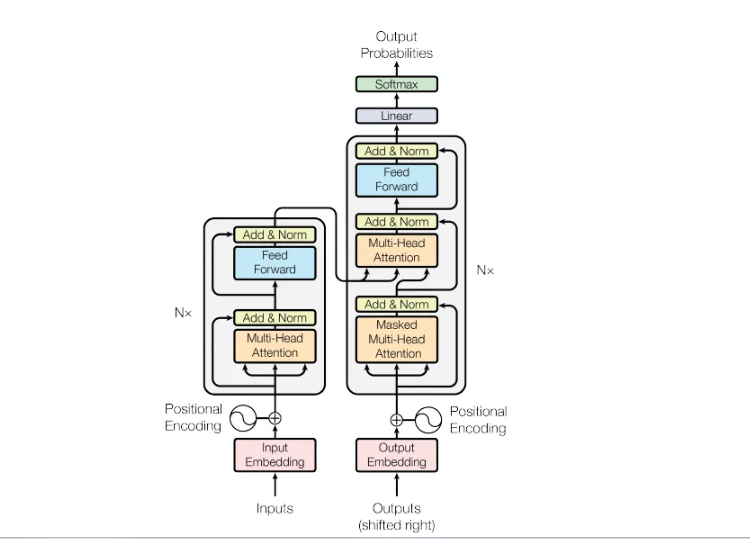

In [3790]:
class Transformer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers,
                max_seq_len, ar_vocab_size, english_to_index, arabic_to_index,
                START_TOKEN, END_TOKEN, PADDING_TOKEN
                ):
        super().__init__()
        self.enc_sentence_embedding = SentenceEmbedding(english_to_index, max_seq_len, d_model,START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, dropout_rate, num_layers, max_seq_len)

        self.dec_sentence_embedding = SentenceEmbedding(arabic_to_index, max_seq_len, d_model,START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, dropout_rate, num_layers, max_seq_len)

        self.linear = nn.Linear(d_model, ar_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, x, y, enc_start_token=False, enc_end_token=False, dec_start_token=True, dec_end_token=True):

        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)
        encoder_self_attention_mask = encoder_self_attention_mask.to(self.device)
        decoder_self_attention_mask = decoder_self_attention_mask.to(self.device)
        decoder_cross_attention_mask = decoder_cross_attention_mask.to(self.device)
    
        x = self.enc_sentence_embedding(x, start_token=enc_start_token, end_token=enc_end_token)
        x = self.encoder(x, encoder_self_attention_mask)

        y = self.dec_sentence_embedding(y, start_token=dec_start_token, end_token=dec_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
        out = self.linear(out)
        return out

In [3791]:
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [3792]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('and this', 'it was um', 'what is she doing here', 'i dont like it', ' its none of your business', ' uhhuh', ' others', 'im much your majesty', 'do i make myself clear', 'thank you', 'i bet you do', 'thats enough', 'yeah of course', 'im him', 'you okay', 'no no', 'shes all yours', 'you want the truth', 'how about you', ' goodbye', ' thats okay', 'im sorry', 'i must go', 'maybe we have something in common', 'right alright alright relax', ' have a seat', 'hows it goin', ' are you all right', 'whats up', ' what did you do', 'what happened', 'is this all youve got'), ('و هذه؟', '...لقد كان', 'ما الذي تفعله هناك؟', 'لا أحب ذلك', '-هذا ليس من شأنك', '-نعم .', 'ـ الآخرون؟', 'أنا (ماتش)، فخامتك', 'هل كلامي واضح؟', 'شكرا لكم.', 'أشك في ذلك', 'هذا يكفي !', 'أجل، بالطبع.', 'أنا هو', '-أأنت بخير ؟', 'ـ لا .. لا ..', 'انها لك', 'تريدين الحقيقة ؟', 'ماذا عنك؟', '-وداعا .', '-لا بأس .', 'أنا آسفة', 'أنا يجب أن أذهب', 'ربما لدينا شيء مشترك.', 'حسنا،حسنا إهدأ', '-تفضلي بالجلوس', 'كيف الحال؟', '-هل أن

## Training

In [3793]:
transformer = Transformer(d_model, ffn_hidden,num_heads, dropout_rate, num_layers, max_seq_len,len(index_to_arabic),english_to_index,arabic_to_index,
                          START_TOKEN, END_TOKEN, PADDING_TOKEN)

In [3794]:
criterian = nn.CrossEntropyLoss(ignore_index = arabic_to_index[PADDING_TOKEN], reduction='none')

for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3795]:
transformer.train()
transformer.to(device)
total_loss = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, ar_batch = batch
        optim.zero_grad()
        ar_predictions = transformer(eng_batch,ar_batch)
        labels = transformer.dec_sentence_embedding.batch_tokenize(ar_batch, start_token=False, end_token=True)
        loss = criterian(
            ar_predictions.view(-1, len(arabic_voc)).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == arabic_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        #train_losses.append(loss.item())
        if batch_num % 100 == 0:
            print(f"Iteration num: {batch_num} , training loss: {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"Arabic Translation: {ar_batch[0]}")
            ar_sentence_predicted = torch.argmax(ar_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in ar_sentence_predicted:
              if idx == arabic_to_index[END_TOKEN]:
                break
              predicted_sentence += index_to_arabic[idx.item()]
            print(f"Arabic Prediction: {predicted_sentence}")

            transformer.eval()
            

Epoch 0
Iteration num: 0 , training loss: 6.175731182098389
English: and this
Arabic Translation: و هذه؟
Arabic Prediction: ۅٳٳڀ**ڬڀ٬ڀڀڀۅٳ١ٳڎڀ`ڻڀٳٳڎ_ڀڻ<ڀڀ١ڀڻ_ڀڻ١ڀڀڀڀڀڻ_ڀ


In [ ]:
index_to_english[101]

'<PADDING>'